In [1]:
import sys
sys.path.append('../input-archives/TensorFlow/models/research')
sys.path.append('../src')

In [2]:
from vipir.vipir import vipir as vp
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

## Basic Image Generation

In [3]:
cdf = vp(r"../data/netcdf/WI937_2020004132603.NGI")

In [4]:
cdf.station

'Wallops Island'

In [5]:
cdf.obs_time

datetime.datetime(2020, 1, 4, 13, 26, 3, tzinfo=datetime.timezone.utc)

In [6]:
cdf.station_location

{'longitude': -75.47799682617188,
 'latitude': 37.9370002746582,
 'altitude': 10.0}

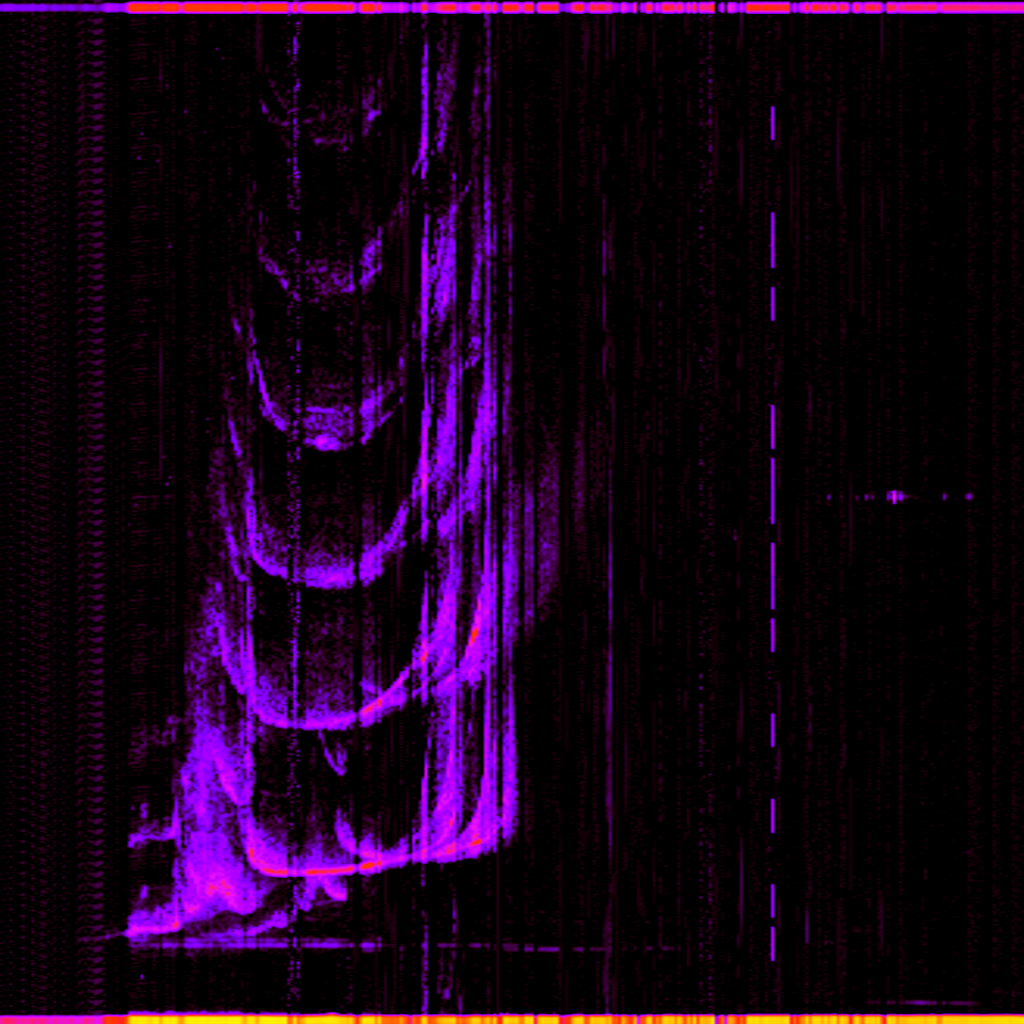

In [7]:
display(cdf.image())

In [8]:
wi2= vp(r'../data/netcdf/WI937_2020016101802.NGI')

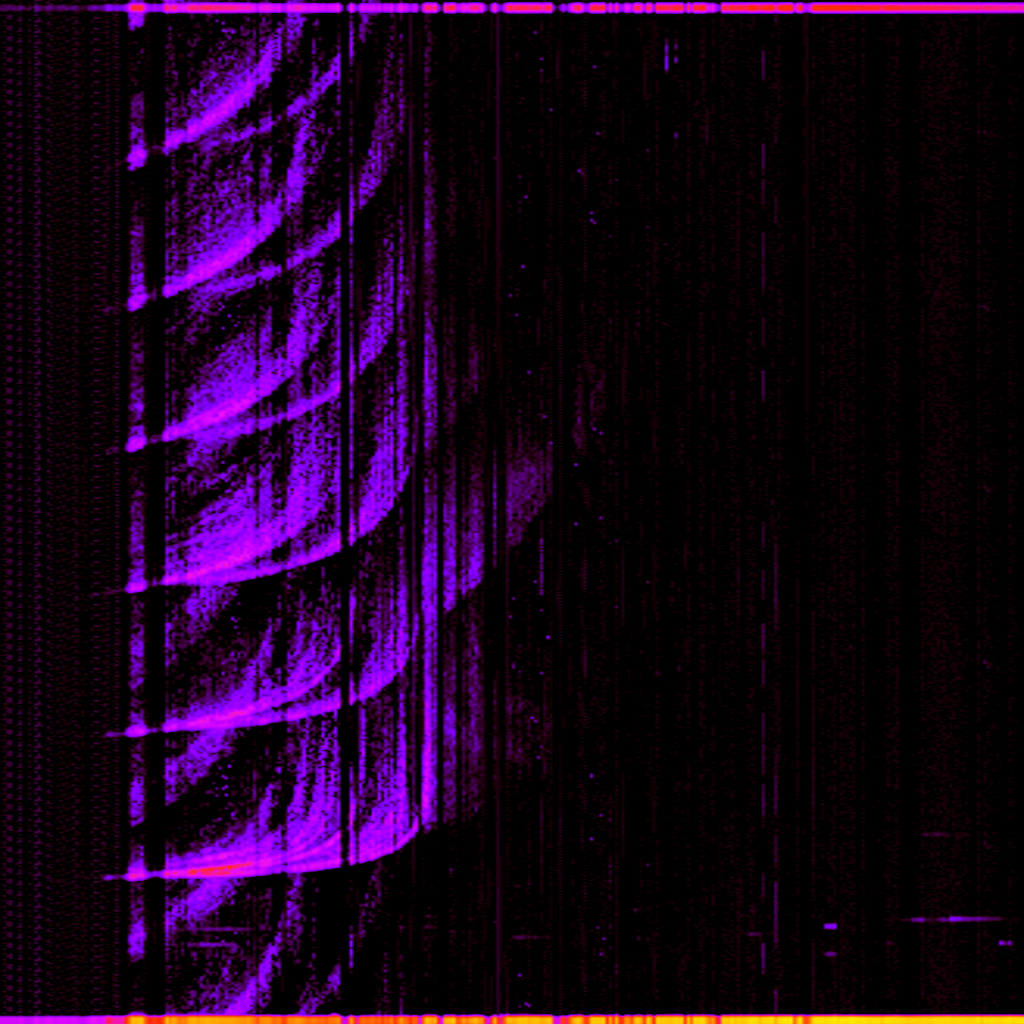

In [9]:
display(wi2.image())

## Apply Annotations

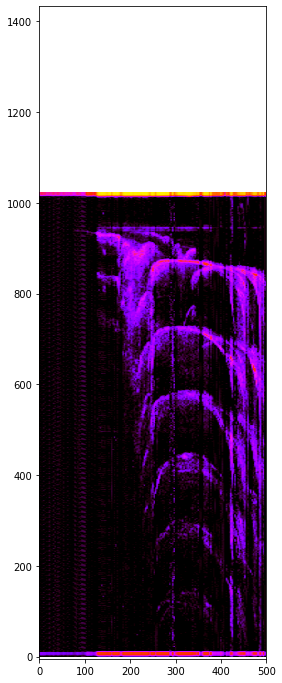

In [11]:
fig, ax = plt.subplots(figsize=(16,12))

ax.axis([0,500, cdf.minrng, cdf.maxrng])
ax.imshow(cdf.image())

In [11]:
[cdf.minfreq, cdf.maxfreq,cdf.minrng, cdf.maxrng]

[1201.0, 22470.455, -4.5010376, 1433.0038]

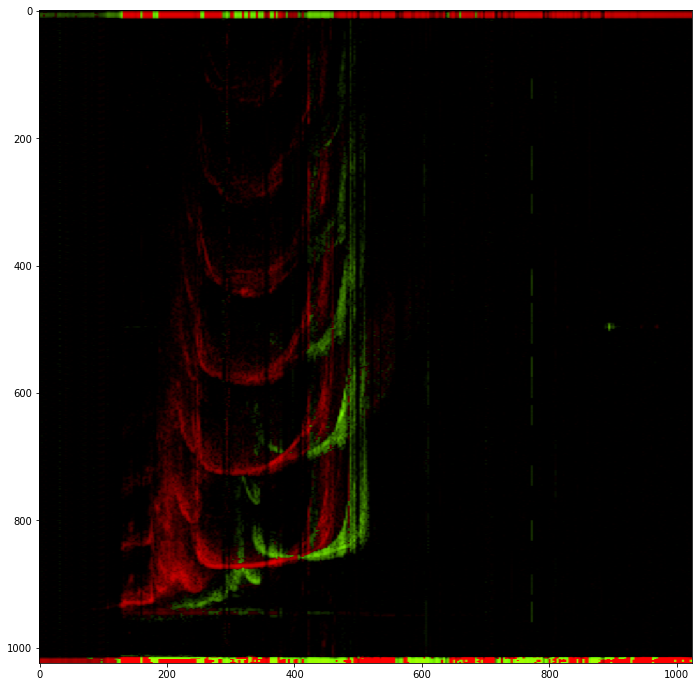

In [18]:
fig, ax = plt.subplots(figsize=(16,12))
ax.imshow(cdf.image())

## Coordinate Transformation

In [36]:
(cdf.minfreq, cdf.maxfreq, cdf.nfreq)

(1201.0, 22470.455, 328)

In [37]:
(cdf.minrng, cdf.maxrng, cdf.nrng)

(-4.5010376, 1433.0038, 960)

## Baseline Plot

In [38]:
cdf.coords_to_pixel((1201.0, -4.5))

AttributeError: 'vipir' object has no attribute 'coords_to_pixel'

In [39]:
cdf.coords_to_pixel((22470.455, cdf.maxrng))

AttributeError: 'vipir' object has no attribute 'coords_to_pixel'

In [40]:
#r = Rectangle((2000,200),3300, 500, edgecolor='r', lw=5, facecolor='none')
box_coords = [(2000,200),(2000,700),(5300, 200), (5300, 700)] # in (freq, rng)

In [34]:
box_pix = [cdf.coords_to_pixel(p) for p in box_coords]

In [35]:
box_pix

[(178, 879), (178, 523), (519, 879), (519, 523)]

In [41]:
from PIL import Image, ImageDraw

im = cdf.image()

draw = ImageDraw.Draw(im)
draw.rectangle([box_pix[0], box_pix[3]],outline='red', width=5)
display(im)

NameError: name 'box_pix' is not defined

## From Processed Files

In [24]:
f = 'SJJ18_2019207182201'
dir = '../models/resnet_train/data/'


In [25]:
!pwd

/home/kevin_leo_mcmanus/vipir/notebooks


In [26]:
im = Image.open(dir+'images/'+f+'.jpg')

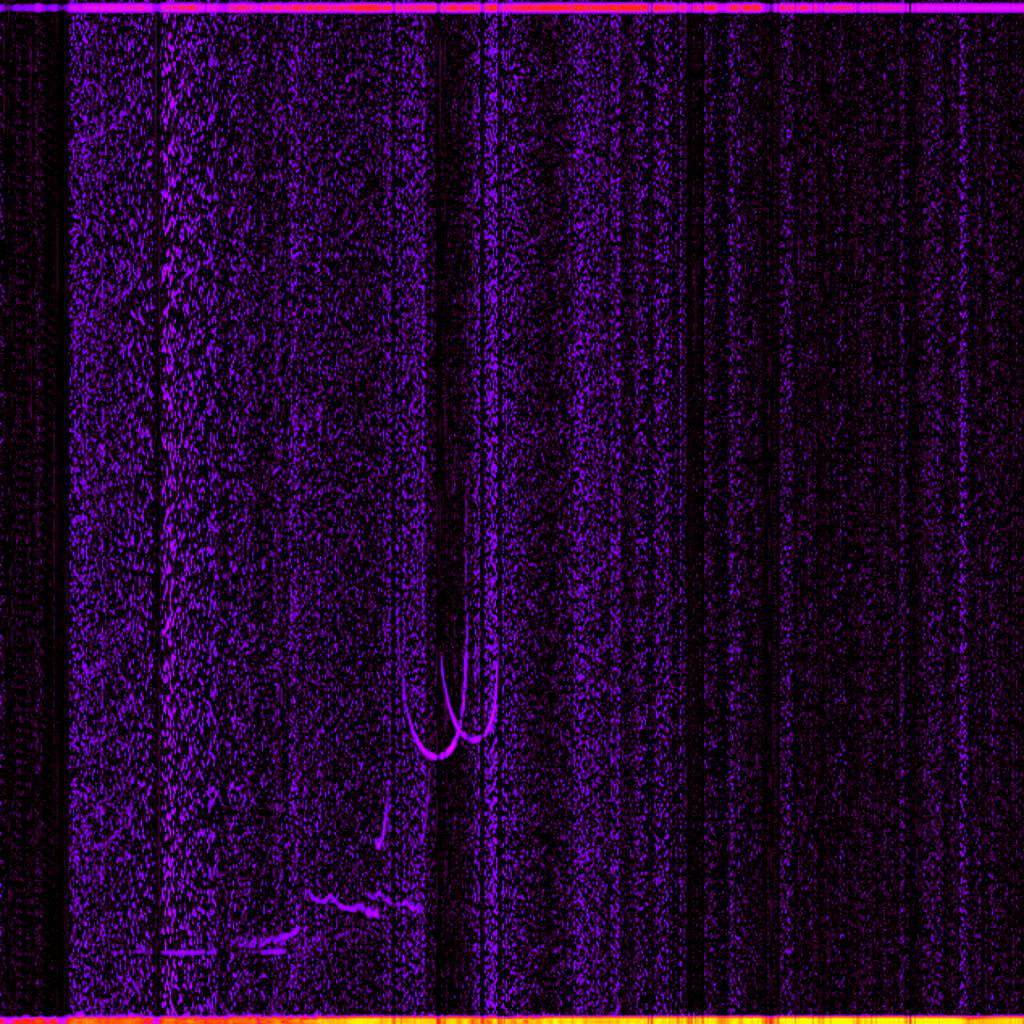

In [27]:
display(im)

In [28]:
mask = Image.open(dir+'trimaps/'+f+'.png')

FileNotFoundError: [Errno 2] No such file or directory: '../models/resnet_train/data/trimaps/SJJ18_2019207182201.png'

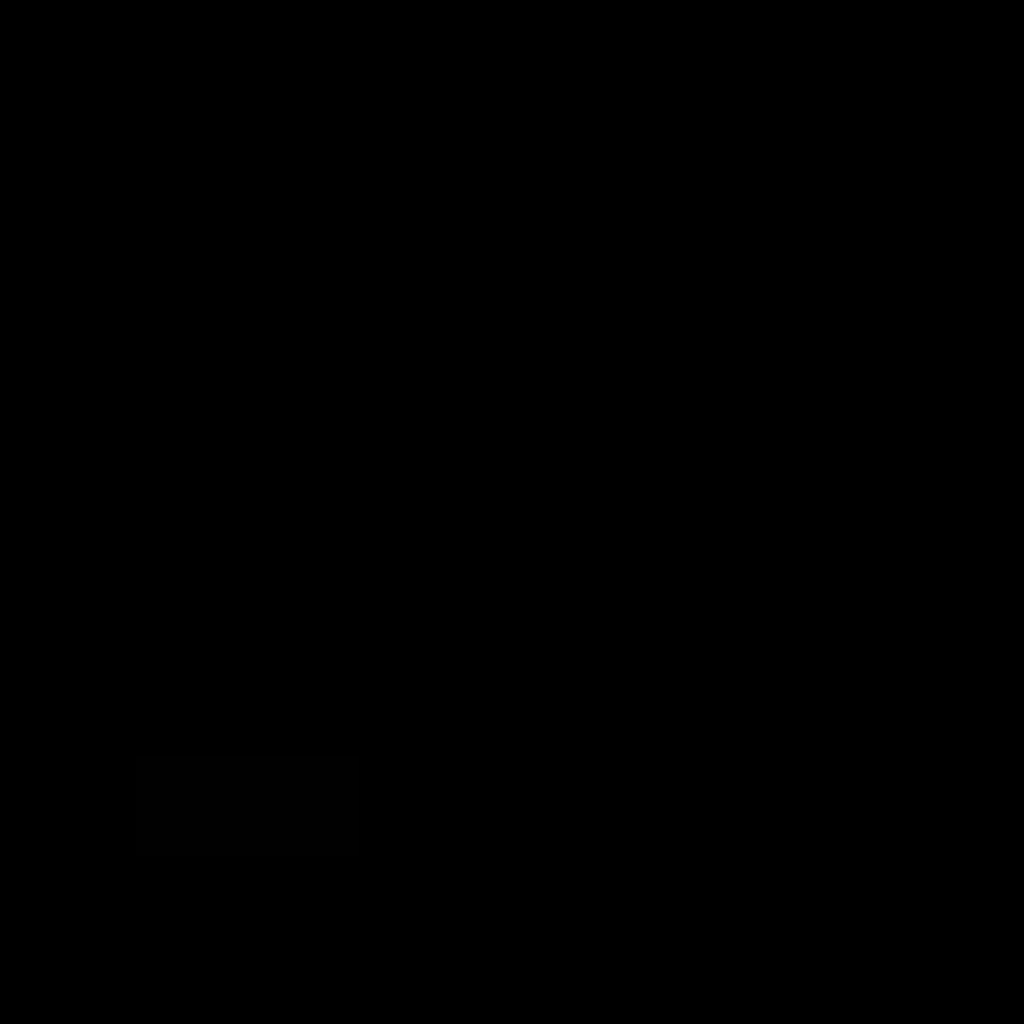

In [16]:
display(mask)

In [24]:
np.asarray(mask).sum()

22300

In [33]:
from xml.etree import ElementTree as ET
from os.path import join

def xmltodict(xmlfile, ALLXMLDIR='../models/resnet_train/data/annotations/xmls'):
    retdict = {}
    xml = ET.parse(join(ALLXMLDIR, xmlfile))
    root_element = xml.getroot()
    retdict['folder'] = root_element.find('folder').text
    retdict['basename'] = root_element.find('filename').text.split('.')[0] # just the basename
    objs = root_element.findall('object')
    # better just be one
    assert(len(objs)==1)
    retdict['name'] = objs[0].find('name').text

    #get the bounding box
    retdict['bndbox'] = {}
    bbox = objs[0].find('bndbox')
    retdict['bndbox']['xmin'] = int(bbox.find('xmin').text)
    retdict['bndbox']['ymin'] = int(bbox.find('ymin').text)
    retdict['bndbox']['xmax'] = int(bbox.find('xmax').text)
    retdict['bndbox']['ymax'] = int(bbox.find('ymax').text)

    return retdict

In [34]:
bbox = xmltodict(f+'.xml')['bndbox']

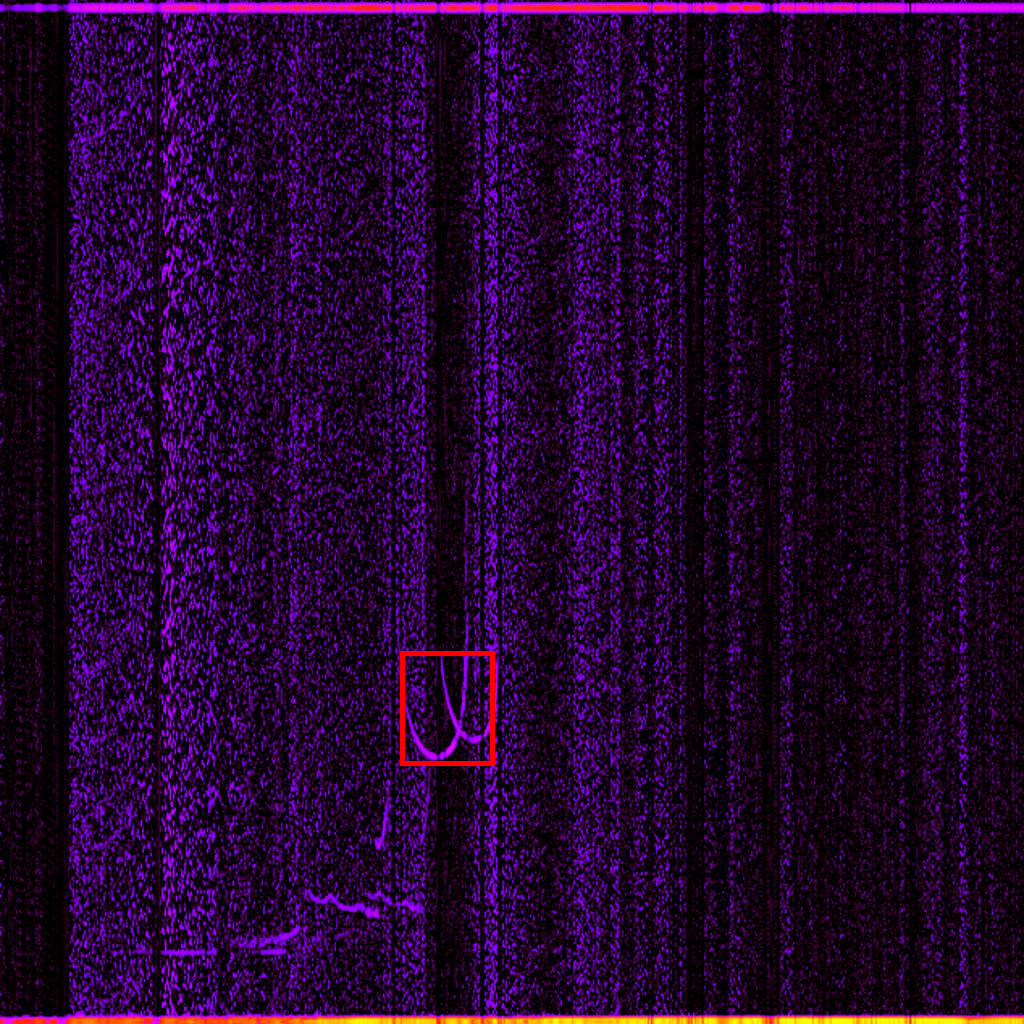

In [35]:
draw = ImageDraw.Draw(im)
draw.rectangle([(bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax'])],outline='red', width=5)
display(im)

In [ ]:
PIL.ImageDraw.ImageDraw.rectangle(xy, fill=None, outline=None, width=0)

In [18]:
import pandas as pd

In [19]:
pd.Timestamp(cdf.obs_time)

Timestamp('2020-01-04 13:26:03+0000', tz='UTC')

In [20]:
snr=cdf.snr()
minsnr = snr.min()
maxsnr = snr.max()

In [21]:
(minsnr, maxsnr)

(-15.980059, 86.2759)

In [22]:
cmap = matplotlib.cm.get_cmap('gnuplot')

In [23]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=100)

In [24]:
cmap(norm(5.0))

(0.21693045781865616, 0.00010421331162222673, 0.2913897468893246, 1.0)

In [25]:
cmap(norm(np.linspace(5.0,7.0,10)), bytes=True)

array([[ 55,   0,  74, 255],
       [ 57,   0,  80, 255],
       [ 57,   0,  80, 255],
       [ 59,   0,  86, 255],
       [ 61,   0,  92, 255],
       [ 61,   0,  92, 255],
       [ 63,   0,  97, 255],
       [ 63,   0,  97, 255],
       [ 65,   0, 103, 255],
       [ 65,   0, 103, 255]], dtype=uint8)

In [26]:
snr_np = cmap(norm(snr.T), bytes=True)

In [27]:
snr_np.shape

(960, 328, 4)

In [28]:
snr_im = Image.fromarray(snr_np, mode='RGBA').transpose(Image.FLIP_TOP_BOTTOM)

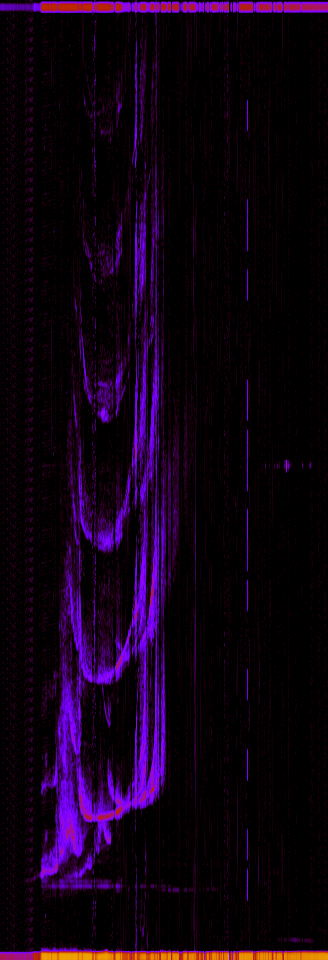

In [29]:
display(snr_im)

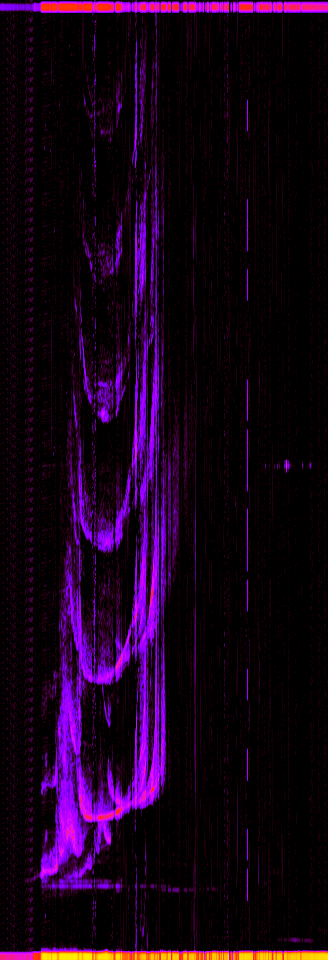

In [30]:
from PIL import ImageEnhance

enh = ImageEnhance.Contrast(snr_im)
display(enh.enhance(1.5))

In [31]:
snr_im.size

(328, 960)

In [32]:
from PIL import ImageDraw

In [33]:
box = [(150,300), (150,450), (225,450), (225,300),(150,300)]

In [34]:
snr_im.size

(328, 960)

In [35]:
def coords_to_pix(freq, rng):
    # the index of freq and rng in their respective arrays are the image pixel indexes
    

SyntaxError: unexpected EOF while parsing (<ipython-input-35-0b842a15c1f2>, line 3)

In [ ]:
snr_im = Image.fromarray(snr_np, mode='RGBA').transpose(Image.FLIP_TOP_BOTTOM)
draw = ImageDraw.Draw(snr_im)
draw.line(box, fill=128, width=5, joint='curve')
draw.point((250,75),fill=255)
#out = Image.alpha_composite(snr_im, draw)
display(snr_im)

In [ ]:
display(snr_im)

In [ ]:
PIL.ImageDraw.ImageDraw.line(xy, fill=None, width=0, joint=None)

In [ ]:
display(test_im)

In [ ]:
test_im=Image.open('testplot.jpg')

In [ ]:
a = np.asarray(test_im)

In [ ]:
a.shape

In [ ]:
a[220,220]

In [ ]:
test_im